In [9]:
import jax
import time
import pypomp
import unittest
import tracemalloc
import jax.numpy as np
import numpy as onp
import pandas as pd

import pykalman
import seaborn as sns
import matplotlib.pyplot as plt
import jax.scipy.special

from tqdm import tqdm
from pypomp.mop import mop
from pypomp.pfilter import pfilter
from pypomp.internal_functions import _mop_internal
from pypomp.internal_functions import _pfilter_internal
from pypomp.internal_functions import _pfilter_internal_mean

In [10]:
jax.config.update("jax_platform_name", "cpu")

In [13]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def logit(x):
    return np.log(x/(1-x))

def get_thetas_dacca(theta):
    gamma = np.exp(theta[0]) # I recovery rate
    m = np.exp(theta[1])  # death probability from cholera
    rho = np.exp(theta[2]) # 1/rho - mean duration of short-term immunity
    epsilon = np.exp(theta[3]) # 1/eps - mean duration of immunity
    omega = np.exp(theta[4]) # mean foi   
    c = sigmoid(theta[5] ) # probability exposure infects 
    beta_trend = theta[6] / 100 # trend in foi
    sigma = np.exp(theta[7]) # stdev of foi perturbations
    tau = np.exp(theta[8]) # stdev of gaussian measurements
    bs = theta[9:15] # seasonality coefficients
    omegas = theta[15:]
    k = 3 # 1/sqrt(k) -  variation coefficient of immune period
    delta = 0.02 # death rate
    return gamma, m, rho, epsilon, omega, c, beta_trend, sigma, tau, bs, omegas, k, delta

def transform_thetas_dacca(gamma, m, rho, epsilon, omega, c, beta_trend, sigma, tau, bs, omegas):
    return np.concatenate([np.array([np.log(gamma), np.log(m), np.log(rho), np.log(epsilon), np.log(omega),
                    logit(c), beta_trend * 100, np.log(sigma), np.log(tau)]), bs, omegas])

def rinit_dacca(theta, J, covars):
    S_0, I_0, Y_0, R1_0, R2_0, R3_0 = 0.621, 0.378, 0, 0.000843, 0.000972, 1.16e-07
    pop = covars[0,2] #the initial whole population P_0
    S = pop*S_0
    I = pop*I_0
    Y = pop*Y_0
    R1 = pop*R1_0
    R2 = pop*R2_0
    R3 = pop*R3_0
    Mn = 0
    t = 0
    count = 0
    return np.tile(np.array([S,I,Y,Mn,R1,R2,R3,t, count]), (J,1)) 

def rinits_dacca(thetas, J, covars):
    return rinit_dacca(thetas[0], len(thetas), covars) 

def dmeas_helper(y, deaths, v, tol, ltol):
    return np.logaddexp(
        jax.scipy.stats.norm.logpdf(y, loc=deaths, scale=v+tol), 
                     ltol) # log(~fy + tol) ~log(fy)

def dmeas_helper_tol(y, deaths, v, tol, ltol): 
    return ltol

def dmeas_dacca(y, preds, theta, keys=None):
    deaths = preds[3]; count = preds[-1]; tol = 1.0e-18
    ltol = np.log(tol)
    gamma, m, rho, epsilon, omega, c, beta_trend, sigma, tau, bs, omegas, k, delta = get_thetas_dacca(theta)
    v = tau*deaths
    #return jax.scipy.stats.norm.logpdf(y, loc=deaths, scale=v)
    return jax.lax.cond(np.logical_or((1-np.isfinite(v)).astype(bool), count>0), #if Y < 0 then count violation
                         dmeas_helper_tol, 
                         dmeas_helper,
                       y, deaths, v, tol, ltol)


dmeasure_dacca = jax.vmap(dmeas_dacca, (None,0,None))  
dmeasures_dacca = jax.vmap(dmeas_dacca, (None,0,0))  


In [14]:
def rproc_dacca(state, theta, key, covar):
    S, I, Y, deaths, pts, t, count = state[0], state[1], state[2], state[3], state[4:-2], state[-2], state[-1]
    t = t.astype(int)
    trends, dpopdts, pops, seass = covar[:,0], covar[:,1], covar[:,2], covar[:,3:]
    gamma, deltaI, rho, eps, omega, clin, beta_trend, sd_beta, tau, bs, omegas, nrstage, delta = get_thetas_dacca(theta)
    dt = 1/240
    deaths = 0
    nrstage = 3
    clin = 1 # HARDCODED SEIR
    rho = 0 # HARDCODED INAPPARENT INFECTIONS
    std = onp.sqrt(dt) #onp.sqrt(onp.sqrt(dt))
    
    neps = eps*nrstage #rate
    rdeaths = np.zeros(nrstage) #the number of death in R1, R2, R3
    passages = np.zeros(nrstage+1)
    

    for i in range(20):
        trend = trends[t]; dpopdt = dpopdts[t]; pop = pops[t]; seas = seass[t]
        beta = np.exp(beta_trend*trend + np.dot(bs, seas))
        omega = np.exp(np.dot(omegas, seas))
        
        subkey, key = jax.random.split(key) 
        dw = jax.random.normal(subkey)*std 
        
        effI = I/pop
        births = dpopdt + delta*pop # births
        passages = passages.at[0].set(gamma*I) # recovery
        ideaths = delta*I # natural i deaths
        disease = deltaI*I # disease death
        ydeaths = delta*Y # natural rs deaths
        wanings = rho*Y # loss of immunity
        
        for j in range(nrstage):
            rdeaths = rdeaths.at[j].set(pts[j]*delta) # natural R deaths
            passages = passages.at[j+1].set(pts[j]*neps) # passage to the next immunity class
            
        infections = (omega+(beta+sd_beta*dw/dt)*effI)*S # infection 
        sdeaths = delta*S # natural S deaths
        
        S += (births - infections - sdeaths + passages[nrstage] + wanings)*dt 
        I += (clin*infections - disease - ideaths - passages[0])*dt
        Y += ((1-clin)*infections - ydeaths - wanings)*dt
        for j in range(nrstage):
            pts = pts.at[j].add((passages[j] - passages[j+1] - rdeaths[j])*dt)
        deaths += disease*dt # cumulative deaths from disease
                        
        count += np.any(np.hstack([np.array([S, I, Y, deaths]), pts]) < 0)
        
        S = np.clip(S, a_min=0); I = np.clip(I, a_min=0); Y = np.clip(Y, a_min=0)
        pts = np.clip(pts, a_min=0); deaths = np.clip(deaths, a_min=0)
        
        t += 1

    return np.hstack([np.array([S, I, Y, deaths]), pts, np.array([t]), np.array([count])])

rprocess_dacca = jax.vmap(rproc_dacca, (0, None, 0, None))

In [15]:
dataset = pd.read_csv('./dacca.csv', index_col=0).reset_index(drop=True)
ys = np.array(dataset['cholera.deaths'].values)
dataset = pd.read_csv('./dacca-covars.csv', index_col=0).reset_index(drop=True)
dataset.index = pd.read_csv('./dacca-covart.csv', index_col=0).reset_index(drop=True).squeeze()
dataset = dataset.reindex(np.array([1891 + i*(1/240) for i in range(12037)])).interpolate()
covars = np.array(dataset.values)

gamma = 20.8
epsilon = 19.1
rho = 0
delta = 0.02
m = 0.06
c = np.array(1)
beta_trend = -0.00498
bs = np.array([0.747, 6.38, -3.44, 4.23, 3.33, 4.55])
sigma = 3.13 #3.13 # 0.77
tau = 0.23 
omega = np.exp(-4.5)
omegas = np.log(np.array([0.184, 0.0786, 0.0584, 0.00917, 0.000208, 0.0124]))

theta = transform_thetas_dacca(gamma, m, rho, epsilon, omega, c, beta_trend, sigma, tau, bs, omegas)
J = 100

pfilter(J = J, rinit = rinit_dacca, rprocess = rprocess_dacca, dmeasure = dmeasure_dacca, theta = theta, ys = ys, covars = covars, thresh = -1)
mop(J = J, rinit = rinit_dacca, rprocess = rprocess_dacca, dmeasure = dmeasure_dacca, theta = theta, ys = ys, covars = covars, alpha = 0.9)

Array(4876.7563, dtype=float32)

In [16]:
def run_pfilter_with_memory(J, rinit, rprocess, dmeasure, theta, ys, covars, thresh):
    tracemalloc.start()  
    try:
        result = pfilter(J=J, rinit=rinit, rprocess=rprocess, dmeasure=dmeasure, 
                         theta=theta, ys=ys, covars=covars, thresh=thresh)
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.reset_peak()
    finally:
        tracemalloc.stop()  
    return result, peak / 1024 /1024

# 100, 500, 1000, 5000, 100000 on GL try LG first (compilation? laptop???)
J_values = [51, 101, 151, 300, 500]  
results = []
memory_usages = []

for J in J_values:
    result, mem_usage = run_pfilter_with_memory(
        J, rinit_dacca, rprocess_dacca, dmeasure_dacca, theta, ys, covars, thresh=-1
    )
    results.append(result)
    memory_usages.append(mem_usage)

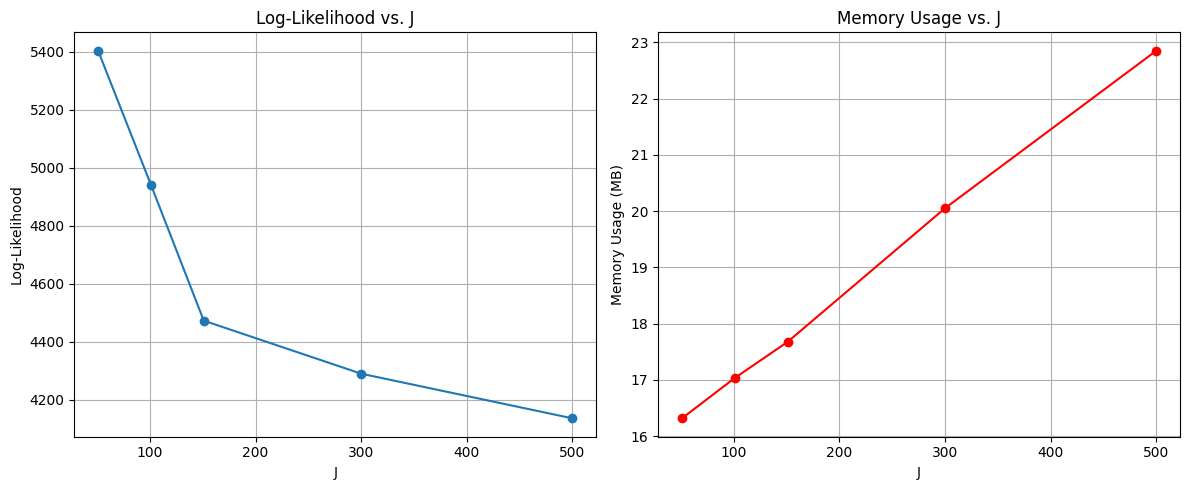

In [17]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(J_values, results, marker='o')
plt.xlabel("J")
plt.ylabel("Log-Likelihood")
plt.title("Log-Likelihood vs. J")
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(J_values, memory_usages, marker='o', color='red')
plt.xlabel("J")
plt.ylabel("Memory Usage (MB)")
plt.title("Memory Usage vs. J")
plt.grid()

plt.tight_layout()
plt.show()